In [364]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


1. Data Cleaning & Exploration
2. 

# 1.Data Cleaning & Exploration

### Importing major libraries

In [365]:
# Required libraries
! pip install feature_engine
import pandas as pd
import numpy as np


# Preprocessing, feature selection and cross validation
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import RFE, SelectKBest, chi2, SelectFromModel, VarianceThreshold
from scipy.stats import skew, kurtosis
from scipy.special import boxcox1p
from sklearn.impute import SimpleImputer
import collections
from feature_engine import categorical_encoders as ce
from feature_engine import discretisers as dsc

# Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet 
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

# Evaluation:
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error


# Visualization & Settings:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)
params = {
'axes.labelsize': "large",
'xtick.labelsize': 'x-large',
'legend.fontsize': 20,
'figure.dpi': 150,
'figure.figsize': [25, 7]}
plt.rcParams.update(params)
pd.set_option('display.max_columns', None)


# Ignore warnings:
import warnings
warnings.filterwarnings('ignore')

In [366]:
# Loading data
train=pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [367]:
# Let's check the shape of the datasets
train.shape, test.shape

((1460, 81), (1459, 80))

In [368]:
# Let's look at some of the rows of the train dataset
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [369]:
# Let's look at some of the rows of the test dataset
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [370]:
# Let's drop Id column as it is not all required
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [371]:
# Let's look at the information of the train dataset including the data dtypes of the columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [372]:
# Let's look at the information of the test dataset including the data dtypes of the columns
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

### Checking NAN values in both train and test datasets

#### Missing in train dataset

In [373]:
missing_train_num=train.isna().sum().sort_values(ascending=False)
missing_train_percent=((train.isna().sum()/len(train))*100).sort_values(ascending=False)

missing_train_all=pd.concat([missing_train_num, missing_train_percent], keys=['total_missing', 'missing_percentage'], axis=1)

missing_train_all=missing_train_all.query("missing_percentage>0")
missing_train_all

,total_missing,missing_percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageCond,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


In [374]:
missing_train_features=missing_train_all.index
len(missing_train_features)

19

#### Missing in test dataset

In [375]:
missing_test_num=train.isna().sum().sort_values(ascending=False)
missing_test_percent=((test.isna().sum()/len(test))*100).sort_values(ascending=False)

missing_test_all=pd.concat([missing_test_num, missing_test_percent], keys=['total_missing', 'missing_percentage'], axis=1)

missing_test_all=missing_test_all.query("missing_percentage>0")
missing_test_all

,total_missing,missing_percentage
PoolQC,1453,99.794380
MiscFeature,1406,96.504455
Alley,1369,92.666210
Fence,1179,80.123372
FireplaceQu,690,50.034270
LotFrontage,259,15.558602
GarageType,81,5.209047
GarageCond,81,5.346127
GarageFinish,81,5.346127
GarageQual,81,5.346127


In [376]:
missing_test_features=missing_test_all.index
len(missing_test_features)

33

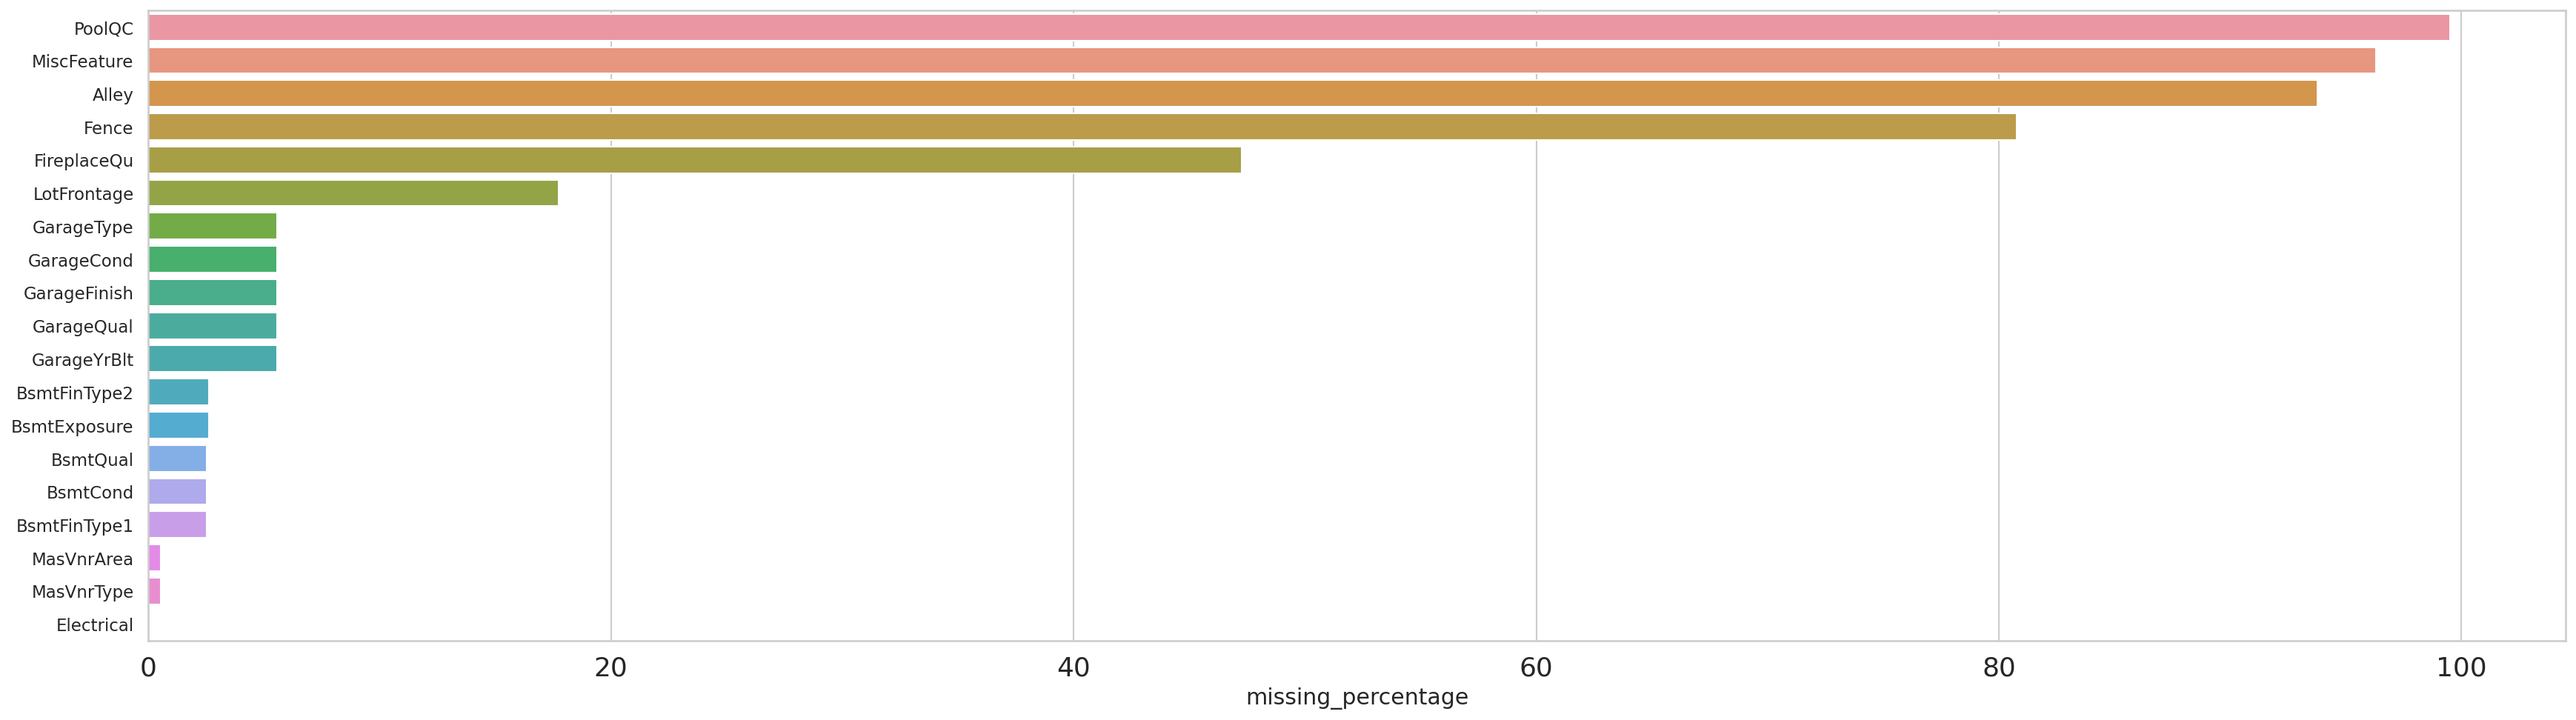

In [377]:

sns.barplot(missing_train_all['missing_percentage'],missing_train_all.index,  orient="h")

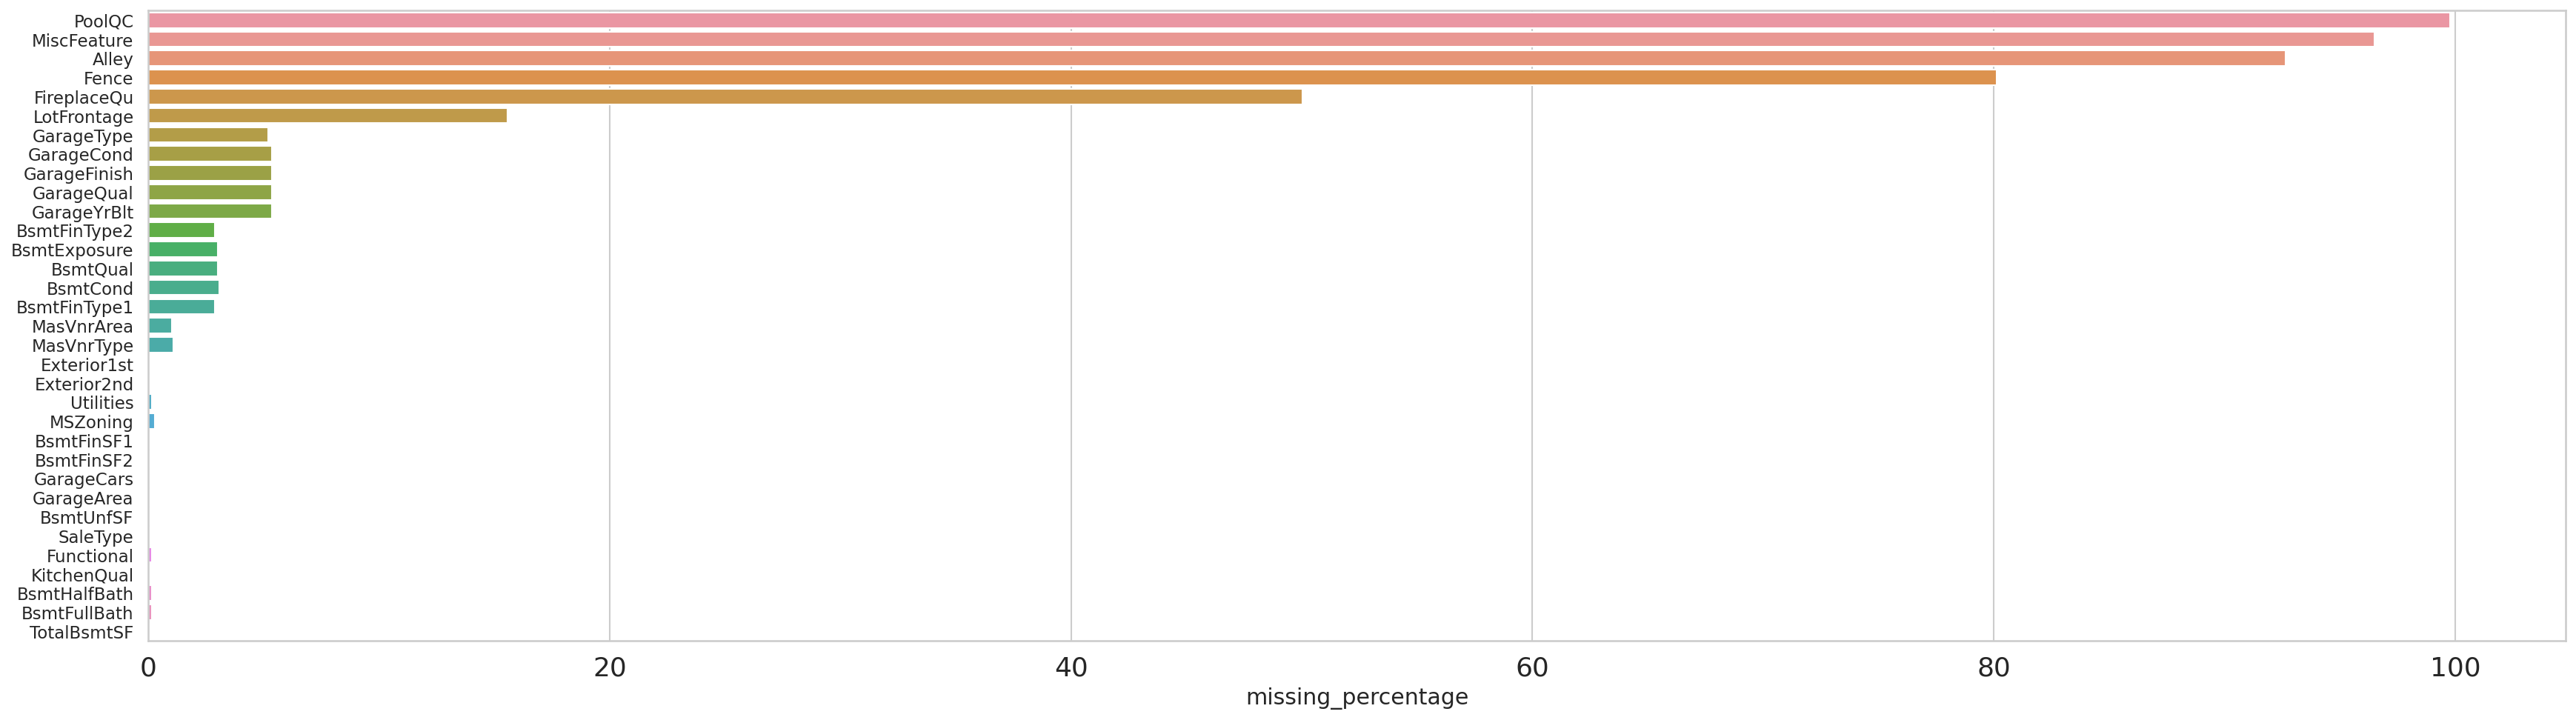

In [378]:
sns.barplot(missing_test_all['missing_percentage'],missing_test_all.index,  orient="h")

##### As we can see above, below are features in both train and test datasets that have missing values >40% . Some of them have missing values greater than 99% as well. we will simply drop these columns <pre> PoolQC, MiscFeature, Alley, Fence, FireplaceQu </pre>

In [379]:
train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
test.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

In [380]:
# Let's cross verify if these columns have been dropped

if any([item in train.columns for item in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']]):
    print("feature(s) still present")
else:
    print("features not present")
    
if any([item in test.columns for item in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']]):
    print("feature(s) still present")
else:
    print("features not present")

features not present
features not present


In [381]:
# Let's seperate numerical and categorical features from train set to check what we will impute in the missing values for the features

numerical_features=[c for c in train.columns if train[c].dtypes!="O" and c!="SalePrice"]
categorical_features=[c for c in train.columns if train[c].dtypes=="O"]

In [382]:
numerical_features

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [383]:
categorical_features

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

### Let's perform GridSearch to find the best imputation technique for both numerical and categorical data

#### Let's create a  pipline and column transformer to check best imputation method

In [384]:
# We create the preprocessing pipelines for both
# numerical and categorical data

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)])




In [385]:
# Now let's create a pipeline to include above transformations and a regression model. "Lasso" as of now.
# Now we have a full prediction pipeline

reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', Lasso(max_iter=3000))])

In [386]:
# Now we create the grid with all the parameters that we would like to test

param_grid = {
    'preprocessor__numerical__imputer__strategy': ['mean', 'median'],
    'preprocessor__categorical__imputer__strategy': ['most_frequent', 'constant'],
    'regressor__alpha': [10, 100, 200],
}

grid_search = GridSearchCV(reg, param_grid, cv=5, iid=False, n_jobs=-1, scoring='r2')

In [387]:
X_train=train.drop('SalePrice', axis=1)
y_train=train['SalePrice']

In [388]:
X_train.shape, y_train.shape, len(X_train.columns), len(categorical_features) + len(numerical_features)

((1460, 74), (1460,), 74, 74)

In [389]:
# Let's fit the gridsearch with X_train and y_train
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                   

In [390]:
print(("best linear regression from grid search: %.3f"
       % (grid_search.score(X_train, y_train))))



best linear regression from grid search: 0.894


In [391]:
grid_search.best_params_

{'preprocessor__categorical__imputer__strategy': 'most_frequent',
 'preprocessor__numerical__imputer__strategy': 'median',
 'regressor__alpha': 200}

#### As seen above, best strategy for imputation is 'most_frequent' or mode for categorical features and 'median' for numerical features. Now we will use this strategy to remove NAN in both train and test data 

In [392]:
# Let's create simpleimputer objects and fit & transform on train and then transform on test data
num_impute=SimpleImputer(strategy='median')
cat_impute=SimpleImputer(strategy='most_frequent')


In [393]:
# Let's create a copy of train and test set and name them as train_transformed and test_transformed

train_transformed=train.copy()
test_transformed=test.copy()

In [394]:
# Now removing the NAN values

train_transformed[numerical_features]=num_impute.fit_transform(train_transformed[numerical_features])
train_transformed[categorical_features]=cat_impute.fit_transform(train_transformed[categorical_features])
test_transformed[numerical_features]=num_impute.transform(test_transformed[numerical_features])
test_transformed[categorical_features]=cat_impute.transform(test_transformed[categorical_features])

In [395]:
# Let's verify that there is no null value in both train and test set now
train_transformed.isnull().sum().sum(), test_transformed.isnull().sum().sum()

(0, 0)

So, null values have been removed in both train and test set now

### Let's do some EDA of the data now to understand it in a better way

EDA of the Train set

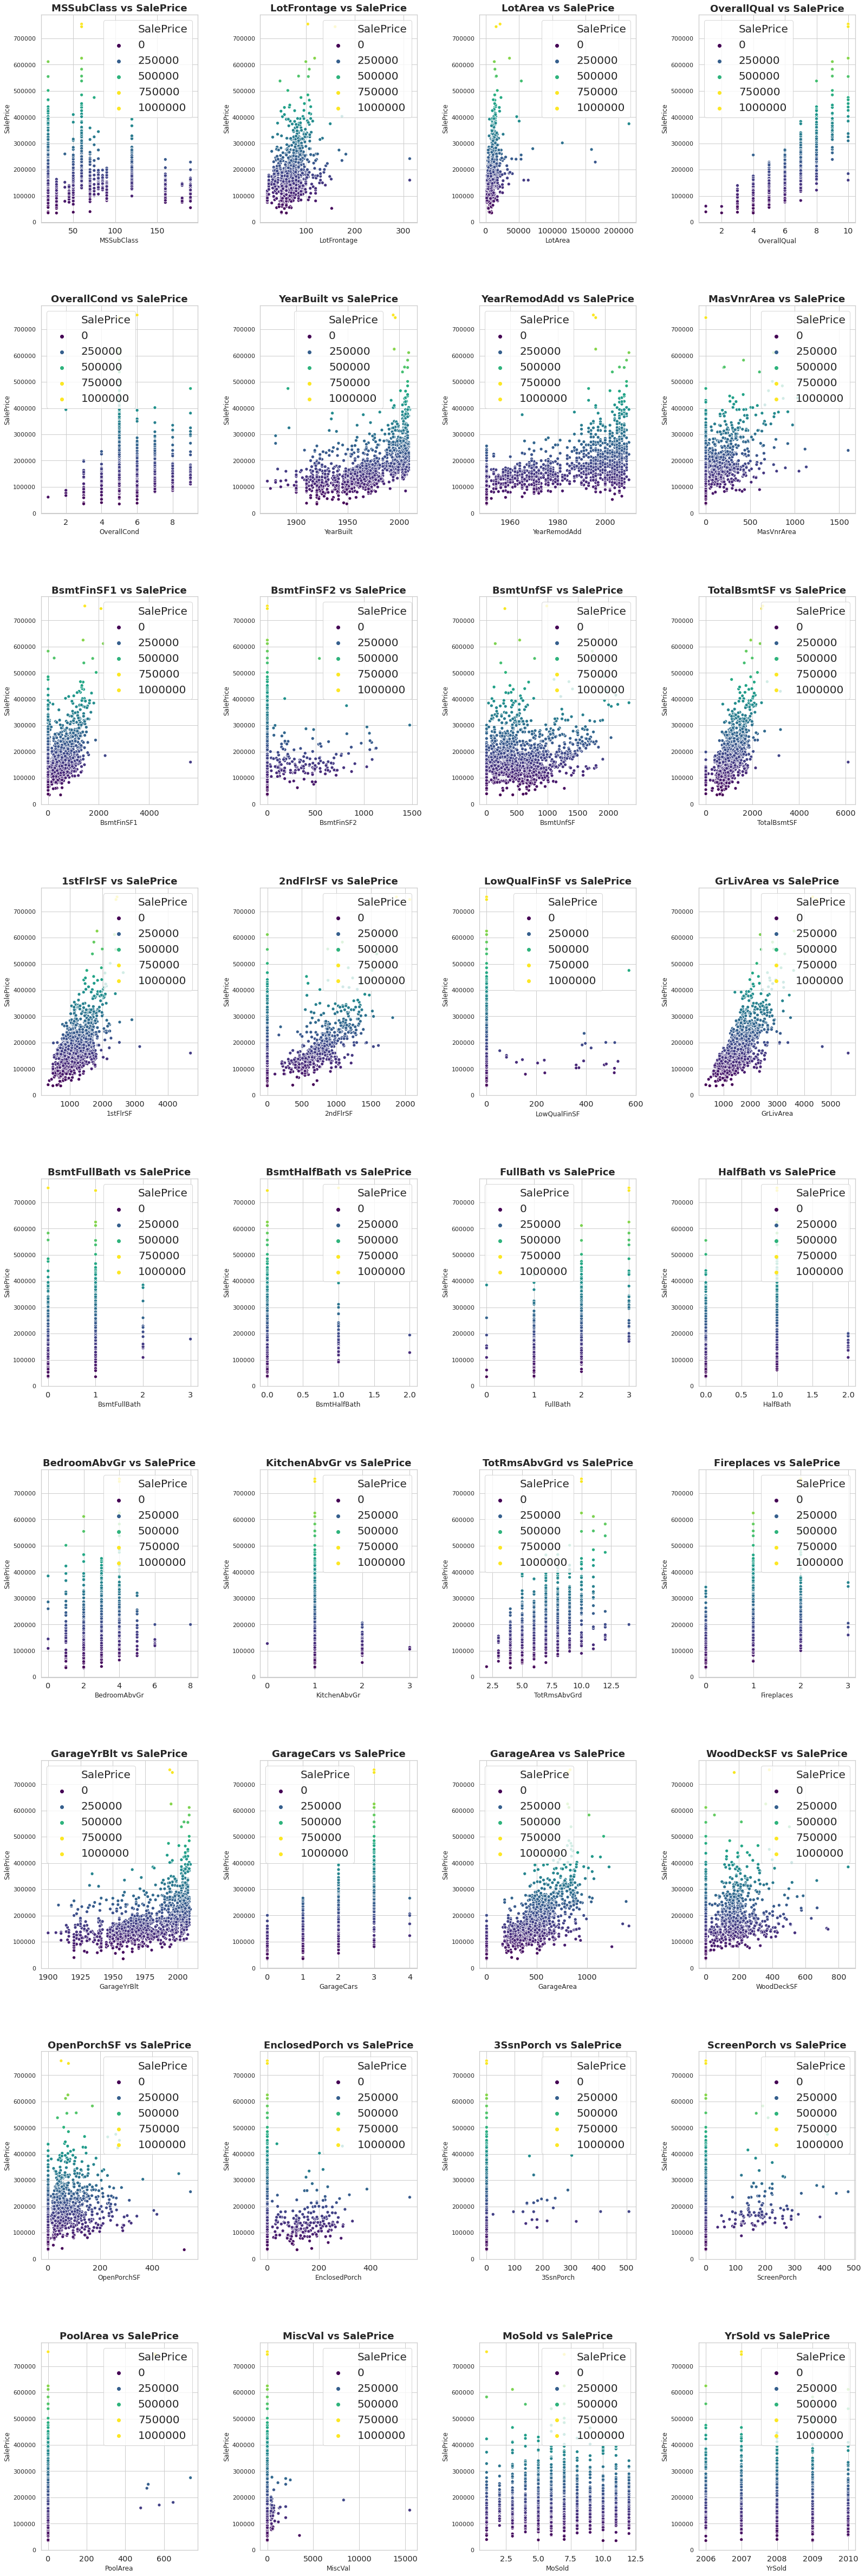

In [396]:
# Numerical features with "SalePrice"
%matplotlib inline
fig=plt.figure(figsize=(24,96))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i,feature in enumerate(numerical_features):
    ax=fig.add_subplot(10,4,i+1)
    sns.scatterplot(feature, 'SalePrice',hue='SalePrice',  data=train, ax=ax, palette='viridis')
    ax.set_title(f'{feature} vs SalePrice', fontweight='bold', fontsize=18)
    
plt.show()    


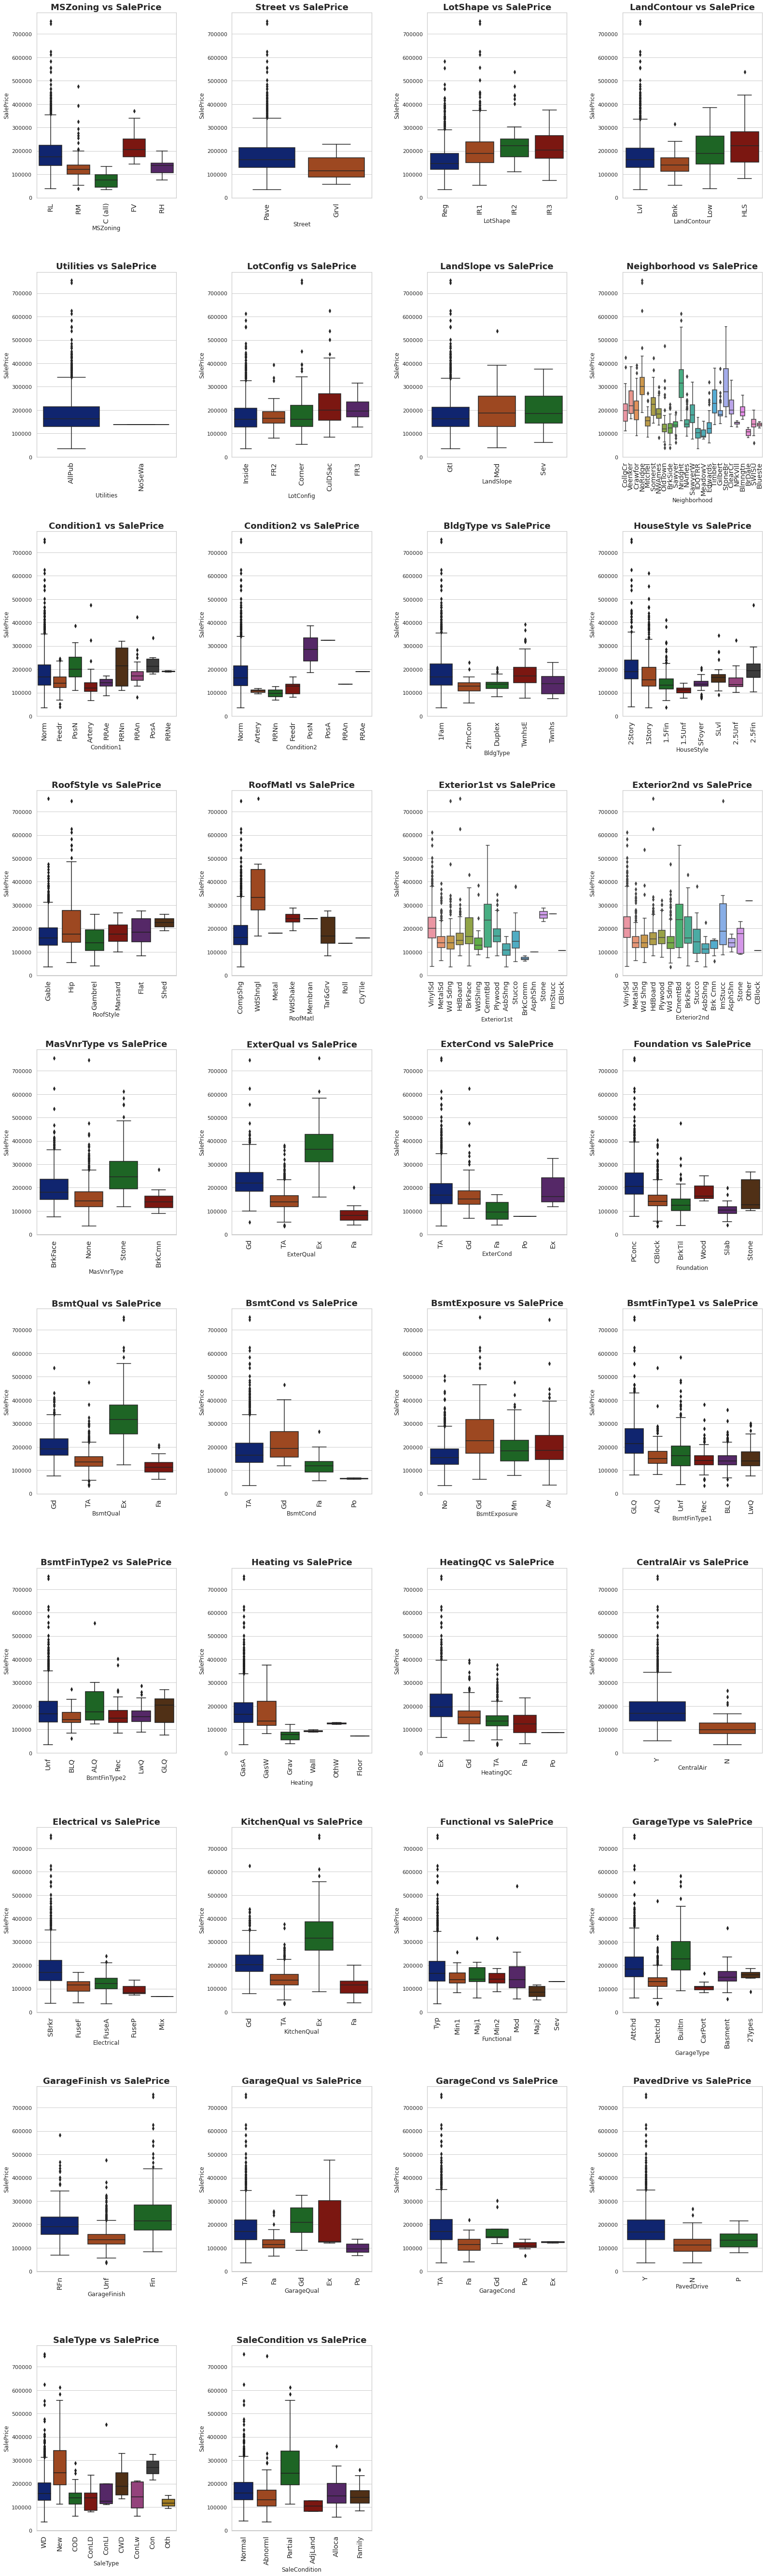

In [397]:
# Categorical features
fig=plt.figure(figsize=(24,96))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i,feature in enumerate(categorical_features):
    ax=fig.add_subplot(10,4,i+1)
    sns.boxplot(feature, 'SalePrice' , data=train, ax=ax)
    ax.set_title(f'{feature} vs SalePrice', fontweight='bold', fontsize=18)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.show()   

we can see correlation amongst target and different features clearly with the above plots.

## Feature Selection methods

### Using filter methods like constant removal, quasi constant removal and duplicate features removal to improve consistency in the features

In [398]:
train_transformed

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60.0,RL,65.0,8450.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,WD,Normal,208500
1,20.0,RL,80.0,9600.0,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,WD,Normal,181500
2,60.0,RL,68.0,11250.0,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,WD,Normal,223500
3,70.0,RL,60.0,9550.0,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,WD,Abnorml,140000
4,60.0,RL,84.0,14260.0,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60.0,RL,62.0,7917.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6.0,5.0,1999.0,2000.0,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,953.0,953.0,GasA,Ex,Y,SBrkr,953.0,694.0,0.0,1647.0,0.0,0.0,2.0,1.0,3.0,1.0,TA,7.0,Typ,1.0,Attchd,1999.0,RFn,2.0,460.0,TA,TA,Y,0.0,40.0,0.0,0.0,0.0,0.0,0.0,8.0,2007.0,WD,Normal,175000
1456,20.0,RL,85.0,13175.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6.0,6.0,1978.0,1988.0,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790.0,Rec,163.0,589.0,1542.0,GasA,TA,Y,SBrkr,2073.0,0.0,0.0,2073.0,1.0,0.0,2.0,0.0,3.0,1.0,TA,7.0,Min1,2.0,Attchd,1978.0,Unf,2.0,500.0,TA,TA,Y,349.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2010.0,WD,Normal,210000
1457,70.0,RL,66.0,9042.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,9.0,1941.0,2006.0,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275.0,Unf,0.0,877.0,1152.0,GasA,Ex,Y,SBrkr,1188.0,1152.0,0.0,2340.0,0.0,0.0,2.0,0.0,4.0,1.0,Gd,9.0,Typ,2.0,Attchd,19

In [399]:
train_transformed.shape

(1460, 75)

#### In order to use VarianceThreshold method, we need to first encode every categorical into some numerical type as variancethreshold works only on numerical data 

In [400]:
# Let's encode categorical data into numerical data for Variancethreshold to work

train_new=train_transformed.copy()
le=LabelEncoder()
for cat in categorical_features:
    train_new[cat]=le.fit_transform(train_transformed[cat].astype('category'))

    
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   float64
 1   MSZoning       1460 non-null   int64  
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   float64
 4   Street         1460 non-null   int64  
 5   LotShape       1460 non-null   int64  
 6   LandContour    1460 non-null   int64  
 7   Utilities      1460 non-null   int64  
 8   LotConfig      1460 non-null   int64  
 9   LandSlope      1460 non-null   int64  
 10  Neighborhood   1460 non-null   int64  
 11  Condition1     1460 non-null   int64  
 12  Condition2     1460 non-null   int64  
 13  BldgType       1460 non-null   int64  
 14  HouseStyle     1460 non-null   int64  
 15  OverallQual    1460 non-null   float64
 16  OverallCond    1460 non-null   float64
 17  YearBuilt      1460 non-null   float64
 18  YearRemo

In [401]:
train_new.shape, train_transformed.shape

((1460, 75), (1460, 75))

In [402]:
# Constant removal i.e features with only single value throughout the column

constant_filter=VarianceThreshold(threshold=0)
constant_filter.fit(train_new)

VarianceThreshold(threshold=0)

In [403]:
# Let's get the sum of total features

constant_filter.get_support().sum()

75

Since there are 76 features which are equal to the number of features in the original data, hence it means there is no feature with a constant value.

### Quasi constant removal


In [404]:
train_new.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60.0,3,65.0,8450.0,1,3,3,0,4,0,5,2,2,0,5,7.0,5.0,2003.0,2003.0,1,1,12,13,1,196.0,2,4,2,2,3,3,2,706.0,5,0.0,150.0,856.0,1,0,1,4,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,2,8.0,6,0.0,1,2003.0,1,2.0,548.0,4,4,2,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,8,4,208500
1,20.0,3,80.0,9600.0,1,3,3,0,2,0,24,1,2,0,2,6.0,8.0,1976.0,1976.0,1,1,8,8,2,0.0,3,4,1,2,3,1,0,978.0,5,0.0,284.0,1262.0,1,0,1,4,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,3,6.0,6,1.0,1,1976.0,1,2.0,460.0,4,4,2,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,8,4,181500
2,60.0,3,68.0,11250.0,1,0,3,0,4,0,5,2,2,0,5,7.0,5.0,2001.0,2002.0,1,1,12,13,1,162.0,2,4,2,2,3,2,2,486.0,5,0.0,434.0,920.0,1,0,1,4,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,2,6.0,6,1.0,1,2001.0,1,2.0,608.0,4,4,2,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,8,4,223500
3,70.0,3,60.0,9550.0,1,0,3,0,0,0,6,2,2,0,5,7.0,5.0,1915.0,1970.0,1,1,13,15,2,0.0,3,4,0,3,1,3,0,216.0,5,0.0,540.0,756.0,1,2,1,4,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,2,7.0,6,1.0,5,1998.0,2,3.0,642.0,4,4,2,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,8,0,140000
4,60.0,3,84.0,14260.0,1,0,3,0,2,0,15,2,2,0,5,8.0,5.0,2000.0,2000.0,1,1,12,13,1,350.0,2,4,2,2,3,0,2,655.0,5,0.0,490.0,1145.0,1,0,1,4,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,2,9.0,6,1.0,1,2000.0,1,3.0,836.0,4,4,2,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,8,4,250000


In [405]:
quasi_constant=VarianceThreshold(threshold=0.01)
quasi_constant.fit(train_new)


VarianceThreshold(threshold=0.01)

In [406]:
quasi_constant.get_support().sum()

73

As seen above, 2 features have been considered as quasi constant and hence removed, let's see which features are these..

In [407]:
quasi_constant_features_to_remove=[not index for index in quasi_constant.get_support()]
quasi_constant_features_to_remove=train_new.columns[quasi_constant_features_to_remove]
quasi_constant_features_to_remove

Index(['Street', 'Utilities'], dtype='object')

These are the 2 features, let's verify this with nunique() method

In [408]:
train_new['Street'].value_counts()

1    1454
0       6
Name: Street, dtype: int64

In [409]:
train_new['Utilities'].value_counts()

0    1459
1       1
Name: Utilities, dtype: int64

In [410]:
train_new.shape, len(train_transformed.select_dtypes(exclude=np.number).columns)

((1460, 75), 38)

Let's remove these 2 features

In [411]:
train_transformed=train_transformed.drop(['Street', 'Utilities'], axis=1)
test_transformed=test_transformed.drop(['Street', 'Utilities'], axis=1)

train_transformed.shape, test_transformed.shape, train.shape, test.shape

((1460, 73), (1459, 72), (1460, 75), (1459, 74))

### Duplicate feature removal

In [412]:
train_transformed.T.duplicated().sum()

0

#### To check duplicated columns, compare we first transposed all columns to rows and rows to columns. Now we can easily check duplicates in the rows( which is actually each column of the original data)

### Outliers detection

In [413]:
train_transformed.describe([0.1, 0.99, 0.995]).T

,count,mean,std,min,10%,50%,99%,99.5%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.0,50.0,190.00,190.000,190.0
LotFrontage,1460.0,69.863699,22.027677,21.0,49.0,69.0,137.41,152.705,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,5000.0,9478.5,37567.64,53422.285,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.0,6.0,10.00,10.000,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.0,5.0,9.00,9.000,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1924.9,1973.0,2009.00,2009.000,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1950.0,1994.0,2009.00,2009.000,2010.0
MasVnrArea,1460.0,103.117123,180.731373,0.0,0.0,0.0,791.28,959.365,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.0,383.5,1572.41,1753.430,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.0,0.0,830.38,1049.330,1474.0


As seen above, these are the columns which require further focus to check their outliers visually to decide how to handle them.
<pre> LotArea, BsmtFinSF1, TotalBsmtSF, MiscVal, GrLivArea </pre>

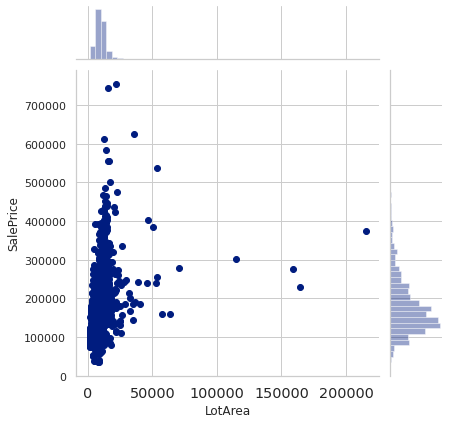

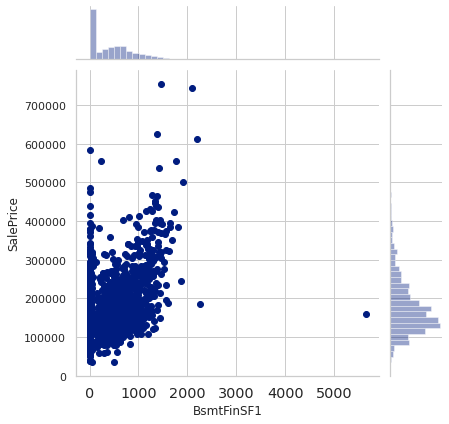

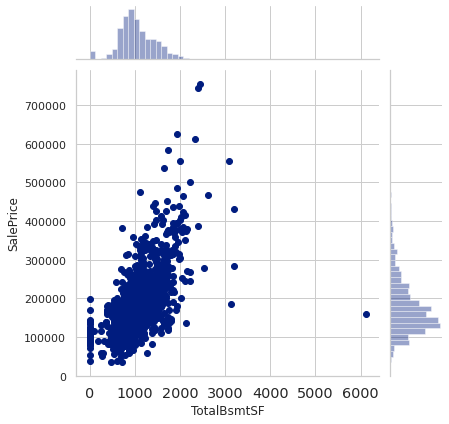

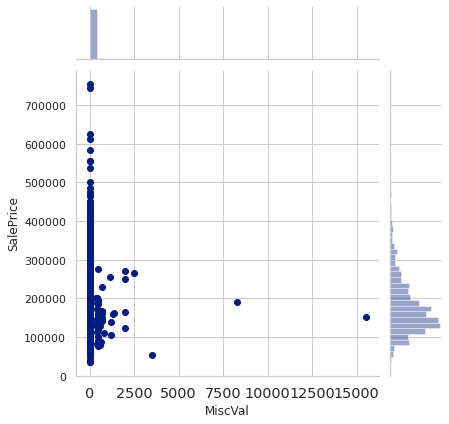

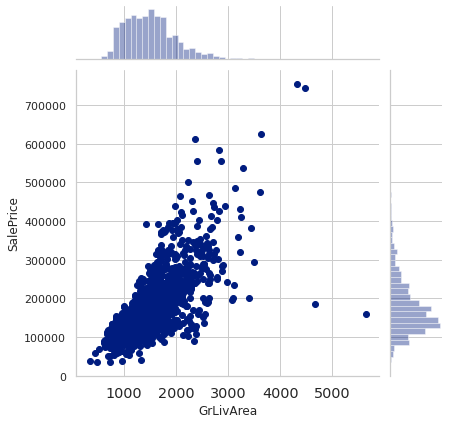

In [414]:
# Let's check the jointplot for these features w.r.t SalePrice

outlier_cols_to_check=['LotArea', 'BsmtFinSF1', 'TotalBsmtSF', 'MiscVal', 'GrLivArea'] 

for col in outlier_cols_to_check:
    sns.jointplot(col, 'SalePrice', data=train_transformed)
    

As seen above, clearly there are outliers that need to be dealt

In [415]:
for col in outlier_cols_to_check:
    q1=train_new[col].quantile([0.01]).values[0]
    q99=train_new[col].quantile([0.99]).values[0]
    
    train_new.loc[train_new[col]>q99*3, col]=q99*3
    train_new.loc[train_new[col]<q1*0.33, col]= q1*0.33

# Feature Engineering

In [416]:
train_transformed.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60.0,RL,65.0,8450.0,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,WD,Normal,208500
1,20.0,RL,80.0,9600.0,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,WD,Normal,181500
2,60.0,RL,68.0,11250.0,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,WD,Normal,223500
3,70.0,RL,60.0,9550.0,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,WD,Abnorml,140000
4,60.0,RL,84.0,14260.0,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,WD,Normal,250000


### Let's make fresh segregation of categorical and numerical features and further of numerical into continuous and discrete featuress

In [417]:
categorical_features=[x for x in train_transformed.columns if train_transformed[x].dtypes=='O']
numerical_features=[x for x in train_transformed.columns if train_transformed[x].dtypes !='O' and x!='SalePrice']

In [418]:
len(categorical_features), len(numerical_features), len(train_transformed.columns)

(36, 36, 73)

In [419]:
numerical_features

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [420]:
# Let's further segregate numerical features

year_features=[x for x in numerical_features if  "Year" in x or "Yr" in x or "year" in x]
year_features

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

#### Let's create new columns now

In [421]:
# focus on the columns containing "Year" or "Yr"
train_transformed[year_features].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
0,2003.0,2003.0,2003.0,2008.0
1,1976.0,1976.0,1976.0,2007.0
2,2001.0,2002.0,2001.0,2008.0
3,1915.0,1970.0,1998.0,2006.0
4,2000.0,2000.0,2000.0,2008.0


Let's create columns with differenced values from YrSold as it will be more useful in understandint the age, renovation age etc.

In [422]:
def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

In [423]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    train_transformed = elapsed_years(train_transformed, var)
    test_transformed = elapsed_years(test_transformed, var)

In [424]:
# drop YrSold
train_transformed.drop('YrSold', axis=1, inplace=True)
test_transformed.drop('YrSold', axis=1, inplace=True)

In [425]:
def create_features(features):
    
    features['TotalSF'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                       features['1stFlrSF'] + features['2ndFlrSF'])
    features['TotalBathrooms'] = (features['FullBath'] +
                              (0.5 * features['HalfBath']) +
                              features['BsmtFullBath'] +
                              (0.5 * features['BsmtHalfBath']))

    features['TotalPorchSF'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                            features['EnclosedPorch'] +
                            features['ScreenPorch'] + features['WoodDeckSF'])

    features['HasPool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    features['Has2ndFloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
  
    
    return features

In [426]:
train_transformed=create_features(train_transformed)
test_transformed=create_features(test_transformed)

In [427]:
categorical_features=[x for x in train_transformed.columns if train_transformed[x].dtypes=='O']
numerical_features=[x for x in train_transformed.columns if train_transformed[x].dtypes !='O' and x!='SalePrice']

In [428]:
len(numerical_features), len(categorical_features), train_transformed.shape

(40, 36, (1460, 77))

In [429]:
discrete_features=[]

for col in numerical_features:
    if train_transformed[col].nunique()<20 and col not in year_features:
        print(f'feature {col} has total unique values {train_transformed[col].nunique()}')
        discrete_features.append(col)
        
print()
print(f"Total discrete features are {len(discrete_features)}")

feature MSSubClass has total unique values 15
feature OverallQual has total unique values 10
feature OverallCond has total unique values 9
feature BsmtFullBath has total unique values 4
feature BsmtHalfBath has total unique values 3
feature FullBath has total unique values 4
feature HalfBath has total unique values 3
feature BedroomAbvGr has total unique values 8
feature KitchenAbvGr has total unique values 4
feature TotRmsAbvGrd has total unique values 12
feature Fireplaces has total unique values 4
feature GarageCars has total unique values 5
feature PoolArea has total unique values 8
feature MoSold has total unique values 12
feature TotalBathrooms has total unique values 10
feature HasPool has total unique values 2
feature Has2ndFloor has total unique values 2

Total discrete features are 17


In [430]:
# Let's change the datatype of these discrete features as object
train_transformed[discrete_features]=train_transformed[discrete_features].astype('O')
test_transformed[discrete_features]=test_transformed[discrete_features].astype('O') 

#### Let's create feature engineering pipeline now

In [486]:
numerical_features_new=[x for x in numerical_features if x not in year_features]

In [483]:
preprocessor=Pipeline([
    
    # categorical encoding
    ('rare_label_encode', ce.RareLabelCategoricalEncoder(
    tol=0.05, replace_with='Rare', n_categories=6, variables=categorical_features)),
    ('categorical_enc', ce.OrdinalCategoricalEncoder(
    encoding_method='ordered', variables=(categorical_features+discrete_features))),
    
    # discretisation + encoding
    ('discretization', dsc.EqualFrequencyDiscretiser(
    q=6, return_object=True, variables=numerical_features_new)),
    ('encoding', ce.OrdinalCategoricalEncoder(
    encoding_method='ordered', variables=numerical_features_new)),
    
])

In [465]:
# Let's convert the train set into train set and test set. Remember this is not the only final test set.
X=train_transformed.drop('SalePrice', axis=1)
y=train_transformed['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [466]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1168, 76), (292, 76), (1168,), (292,))

0

In [484]:
# Now let us preprocess X_train and X_test

X_train_tx=preprocessor.fit_transform(X_train, y_train)

X_test_tx=preprocessor.transform(X_test)

ValueError: Some of the variables to transform contain missing values. Check and remove those before using this transformer.

In [485]:
X_test[.isnull().values.any()

False